In [ ]:
# !unzip -q '/content/drive/MyDrive/flowers/flowers.zip' -d '/content/flowers'

In [1]:
import os
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
import statistics

In [7]:
image_size = 64
batch_size = 64
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
print(os.getcwd())
DATA_DIR = 'jpg'

print(os.listdir(DATA_DIR))

train_ds = ImageFolder(DATA_DIR, transform=tt.Compose([ tt.Resize(image_size),
                                                        tt.CenterCrop(image_size),
                                                        tt.ToTensor(),
                                                        tt.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

C:\Users\shiva\Desktop\projects
['flowers']


'cuda'

# GENERATOR - DISCRIMINATOR

In [8]:
latent_size = 256

In [9]:
class Generator(nn.Module):
    def __init__(self, latent_size):
        super(Generator, self).__init__()

        # self.embeddings = text_embeddings(input)

        self.main = nn.Sequential(
            # latent_size x 1 x 1
            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 512 x 4 x 4
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 256 x 8 x 8
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 16 x 16
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 32 x 32
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # 3 x 64 x 64
            # nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.Tanh()
            # # 3 x 128 x 128
        )

    def forward(self, x):
        return self.main(x)

generator = Generator(latent_size).to(device)

In [10]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.main = nn.Sequential(
            # # 3 x 128 x 128

            # nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1, bias=False),
            # nn.BatchNorm2d(32),
            # nn.LeakyReLU(0.2, inplace=True),

            # 3 x 64 x 64
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # 64 x 32 x 32
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # 128 x 16 x 16
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # 256 x 8 x 8
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # 512 x 4 x 4
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # 1 x 1 x 1
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

discriminator = Discriminator().to(device)

In [11]:
latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
fake_images = generator(latent)
fake_labels = discriminator(fake_images)
print(fake_images.size(), fake_labels.size())

torch.Size([64, 3, 64, 64]) torch.Size([64, 1])


#TRAINING

In [12]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_images = real_images.to(device)
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [13]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [14]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        loss_d_lst = []
        loss_g_lst = []
        real_score_lst = []
        fake_score_lst = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_d_lst.append(loss_d)
            real_score_lst.append(real_score)
            fake_score_lst.append(fake_score)
            # Train generator
            loss_g = train_generator(opt_g)
            loss_g_lst.append(loss_g)
            
        # Record losses & scores
        loss_g = statistics.mean(loss_g_lst)
        loss_d = statistics.mean(loss_d_lst)
        real_score = statistics.mean(real_score_lst)
        fake_score = statistics.mean(fake_score_lst)

        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # # Save generated images
        # save_samples(epoch+start_idx, fixed_latent, show=False)

        #Show Samples
        # latent = torch.randn(1, latent_size, 1, 1, device=device)
        # fake_images = generator(latent)
        # print(fake_images.size())
        # fake_images = torch.squeeze(fake_images)
        # print(fake_images.size())
        # plt.imshow(fake_images.permute(1, 2, 0).cpu().detach().numpy())
        # plt.show()
    
    return losses_g, losses_d, real_scores, fake_scores

In [19]:
epochs = 100
lr = 0.0001

history = fit(epochs, lr)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [1/64], loss_g: 4.2504, loss_d: 0.1055, real_score: 0.9539, fake_score: 0.0465


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [2/64], loss_g: 4.2445, loss_d: 0.2205, real_score: 0.9360, fake_score: 0.0638


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [3/64], loss_g: 4.2012, loss_d: 0.0952, real_score: 0.9563, fake_score: 0.0435


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [4/64], loss_g: 4.5535, loss_d: 0.0609, real_score: 0.9708, fake_score: 0.0286


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [5/64], loss_g: 4.7415, loss_d: 0.1648, real_score: 0.9644, fake_score: 0.0404


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [6/64], loss_g: 4.2010, loss_d: 0.1408, real_score: 0.9429, fake_score: 0.0518


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [7/64], loss_g: 4.6640, loss_d: 0.0582, real_score: 0.9722, fake_score: 0.0271


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [8/64], loss_g: 4.7810, loss_d: 0.0568, real_score: 0.9736, fake_score: 0.0261


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [9/64], loss_g: 4.9117, loss_d: 0.0506, real_score: 0.9761, fake_score: 0.0237


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [10/64], loss_g: 5.0595, loss_d: 0.0551, real_score: 0.9743, fake_score: 0.0252


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [11/64], loss_g: 5.0941, loss_d: 0.0448, real_score: 0.9786, fake_score: 0.0211


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [12/64], loss_g: 5.1359, loss_d: 0.0471, real_score: 0.9776, fake_score: 0.0220


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [13/64], loss_g: 4.3327, loss_d: 1.2244, real_score: 0.8698, fake_score: 0.1360


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [14/64], loss_g: 3.6525, loss_d: 0.2427, real_score: 0.9045, fake_score: 0.0946


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [15/64], loss_g: 4.4854, loss_d: 0.0751, real_score: 0.9648, fake_score: 0.0344


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [16/64], loss_g: 4.7159, loss_d: 0.0538, real_score: 0.9744, fake_score: 0.0253


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [17/64], loss_g: 4.9664, loss_d: 0.0504, real_score: 0.9759, fake_score: 0.0236


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [18/64], loss_g: 5.0904, loss_d: 0.0405, real_score: 0.9805, fake_score: 0.0193


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [19/64], loss_g: 5.0946, loss_d: 0.0379, real_score: 0.9815, fake_score: 0.0178


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [20/64], loss_g: 5.2328, loss_d: 0.0471, real_score: 0.9781, fake_score: 0.0219


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [21/64], loss_g: 4.4781, loss_d: 1.2773, real_score: 0.8825, fake_score: 0.1242


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [22/64], loss_g: 4.1388, loss_d: 0.1714, real_score: 0.9308, fake_score: 0.0693


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [23/64], loss_g: 4.6834, loss_d: 0.0722, real_score: 0.9667, fake_score: 0.0327


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [24/64], loss_g: 4.8686, loss_d: 0.0482, real_score: 0.9769, fake_score: 0.0228


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [25/64], loss_g: 5.0887, loss_d: 0.0418, real_score: 0.9798, fake_score: 0.0199


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [26/64], loss_g: 5.1741, loss_d: 0.0448, real_score: 0.9789, fake_score: 0.0209


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [27/64], loss_g: 5.3273, loss_d: 0.0361, real_score: 0.9827, fake_score: 0.0172


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [28/64], loss_g: 5.3449, loss_d: 0.0391, real_score: 0.9811, fake_score: 0.0182


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [29/64], loss_g: 5.4425, loss_d: 0.0398, real_score: 0.9810, fake_score: 0.0185


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [30/64], loss_g: 4.6903, loss_d: 0.6990, real_score: 0.9058, fake_score: 0.0970


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [31/64], loss_g: 4.6598, loss_d: 0.0874, real_score: 0.9611, fake_score: 0.0390


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch [32/64], loss_g: 4.9917, loss_d: 0.0482, real_score: 0.9771, fake_score: 0.0227


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


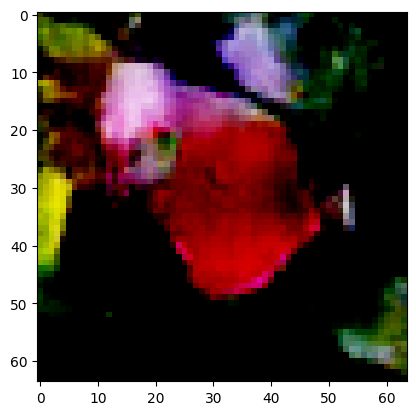

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


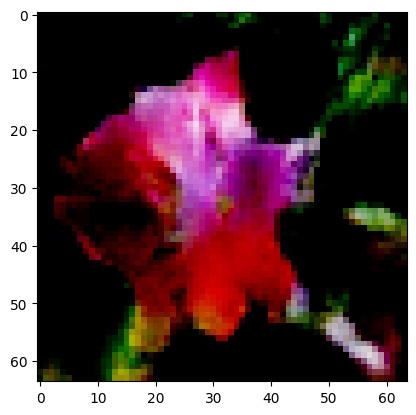

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


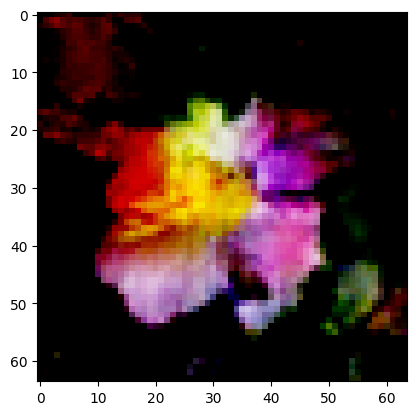

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


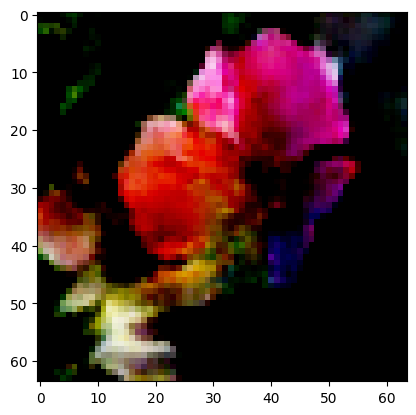

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


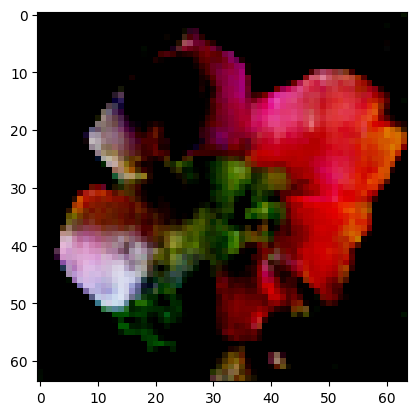

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


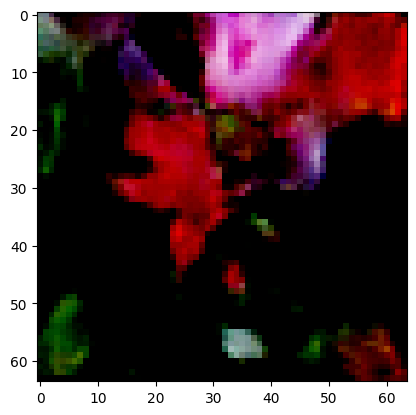

In [22]:
for i in range(6):
    latent = torch.randn(1, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_images = torch.squeeze(fake_images)
    plt.imshow(fake_images.permute(2, 1, 0).cpu().detach().numpy())
    plt.show()